# **Import Statements**

In [6]:
import sys
root = "C:\\Users\\saman\\OneDrive\\Documents\\GitHub\\Eyelid-Modeling\\" #Root path for laptop
#root = "C:\\Users\\Samantha\\Documents\\GitHub\\Eyelid-Modeling\\" #Root path for desktop
sys.path.append(root)

from utils.experiment_manager import Experiment
from models.EMG_RNN import EMG_RNN
from models.EMG_RNN_CNN import EMG_RNN_CNN
from utils.data_management import Mat2TVT

import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

# **Data Reorganization** <br>


In [2]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = root + 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Loading Trained Models**

In [149]:
'''
Loading CNN+RNN Hybrid Model
'''
with open(root + "experiments\\EMG_RNN_CNN\\training_metrics.pickle", "rb") as file:
    metrics = pickle.load(file)

with open(root + "experiments\\EMG_RNN_CNN\\best_params.pickle", "rb") as file:
    best_params = pickle.load(file)

    
'''
Test
'''
experiment = Experiment()
test_metrics, preds = experiment.test_model(best_params, TVT_dict, EMG_RNN_CNN(), metrics['Best Weights'], val = True)

Test Error: 
 Max Marker Error: 1411.3%, Avg Marker Error: 102.2%, Avg loss: 3469.803223 



# **Plotting Loss Metrics**

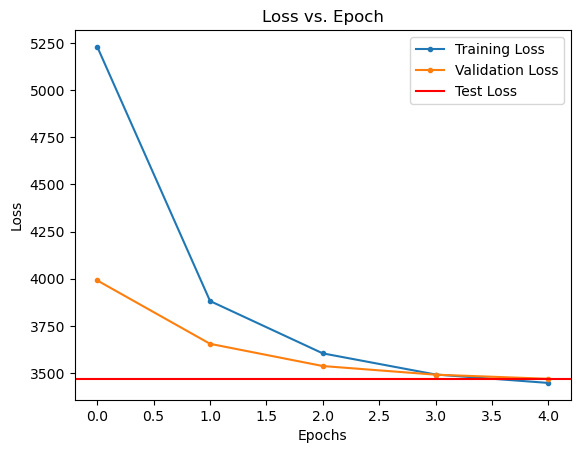

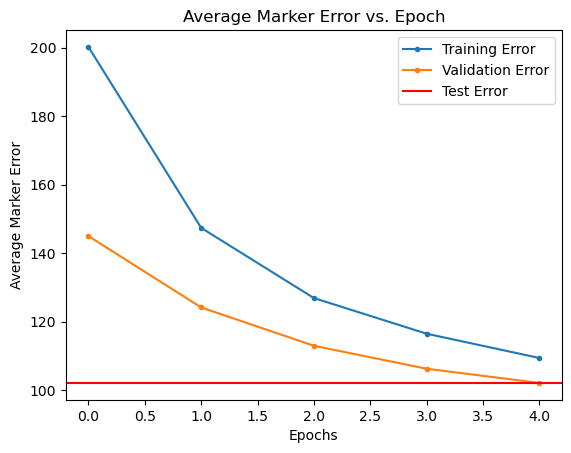

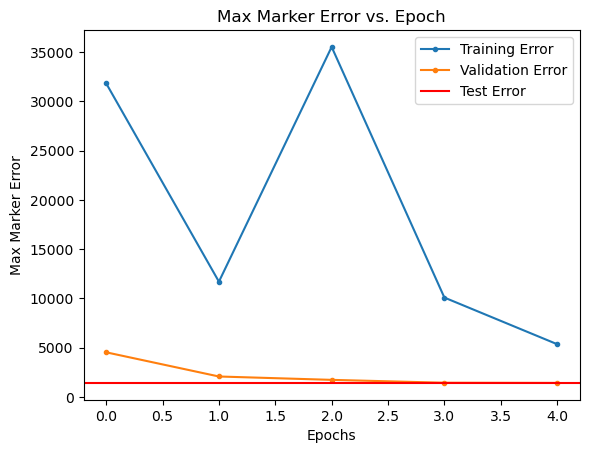

In [ ]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.axhline(test_metrics['Test Loss'], label = 'Test Loss', c = 'red')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.axhline(test_metrics['Test Avg Marker Error'], label = 'Test Error', c = 'red')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.axhline(test_metrics['Test Max Marker Error'], label = 'Test Error', c = 'red')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()

# **Class Visualizations**

In [ ]:
def pred2ts(preds, best_params, yr = 400):
    preds = torch.Tensor(preds).cpu()
    shape = preds.shape
    t_stride = int(best_params['t_stride']*yr*1e-3)
    t_lookahead = best_params['t_lookahead']*1e-3

    pred_ts = np.empty((shape[0], shape[1]*shape[3], shape[2], shape[4]))
    for i in range(shape[3]):
        pred_ts[:, i*t_stride:(i+1)*t_stride, :, :] = np.asarray(preds[:, :, :, i, :])

    t = np.linspace(t_lookahead, t_lookahead + pred_ts.shape[1], pred_ts.shape[1])
    print(pred_ts.shape)
    
    return pred_ts, t

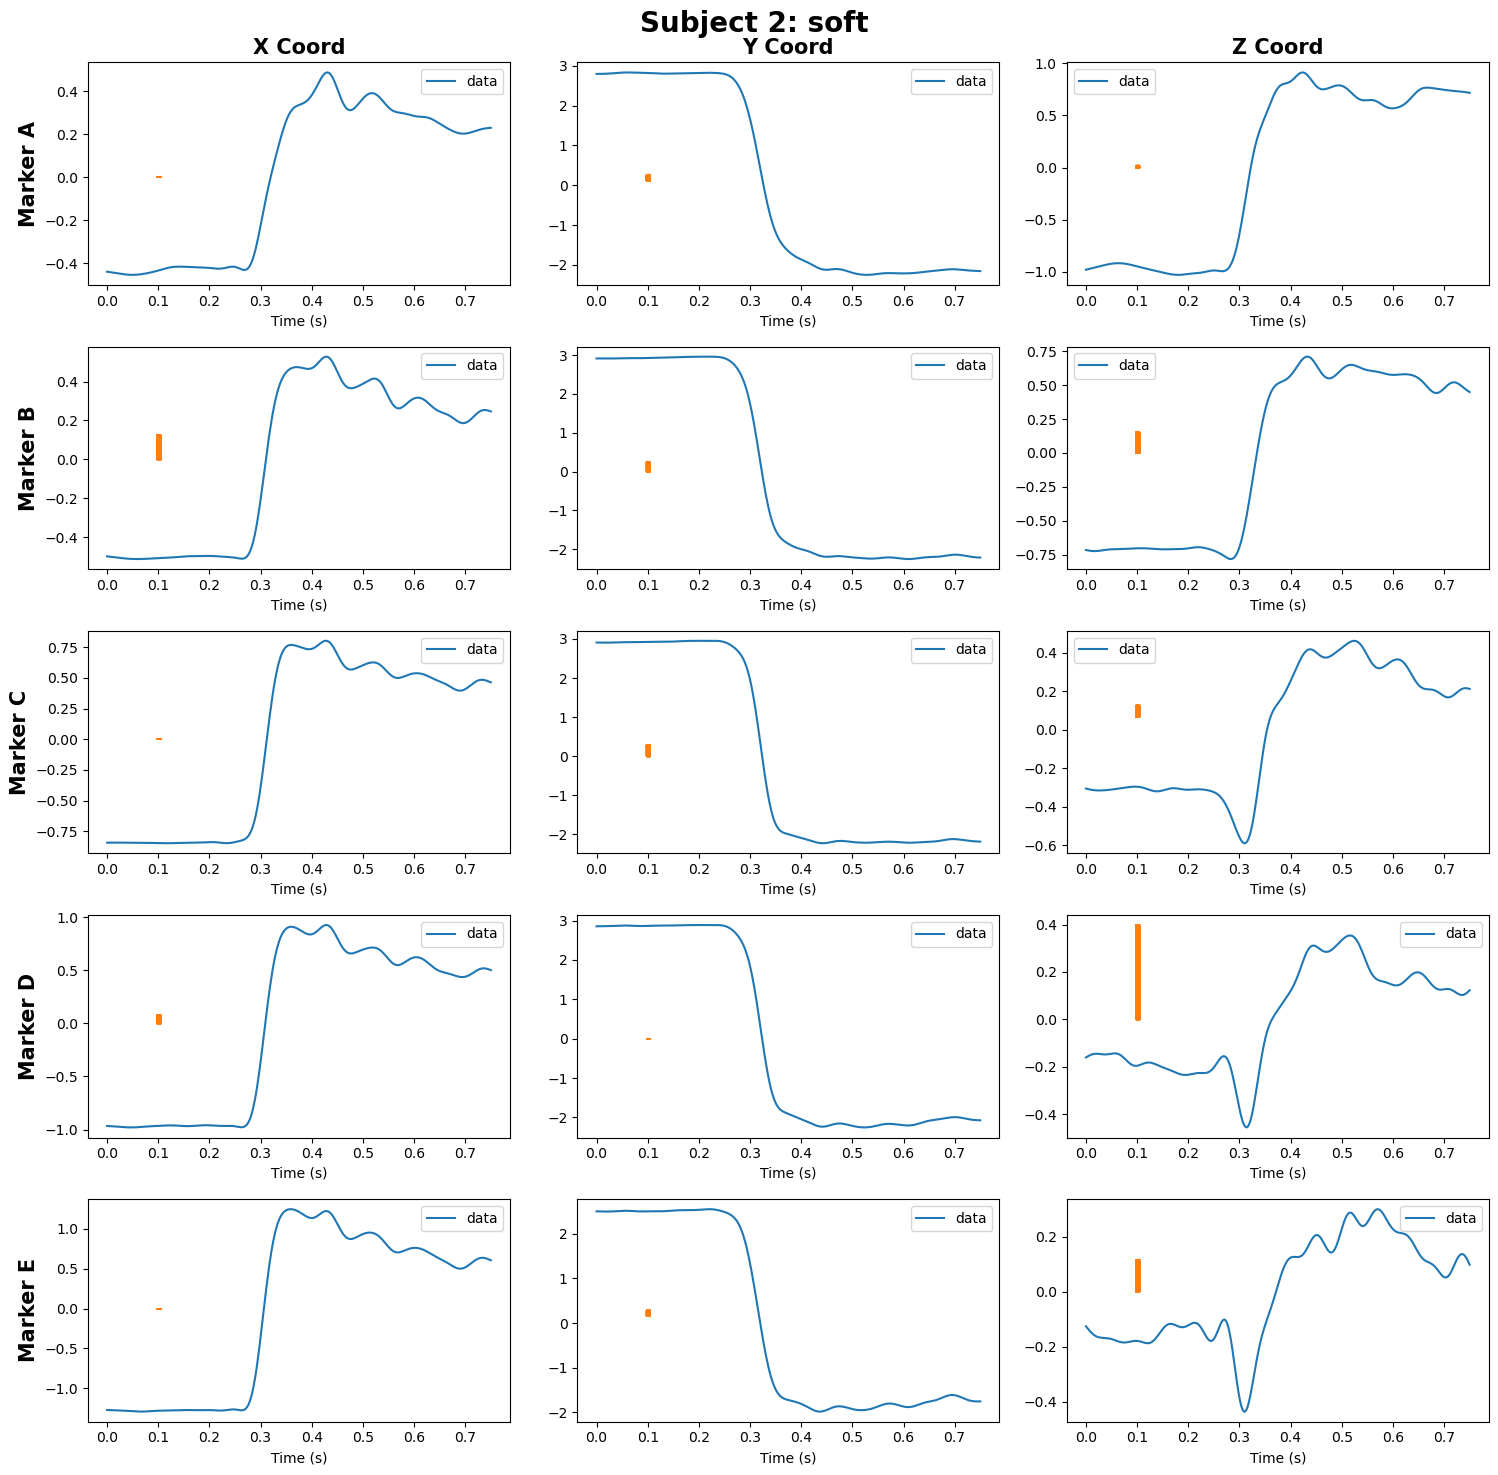

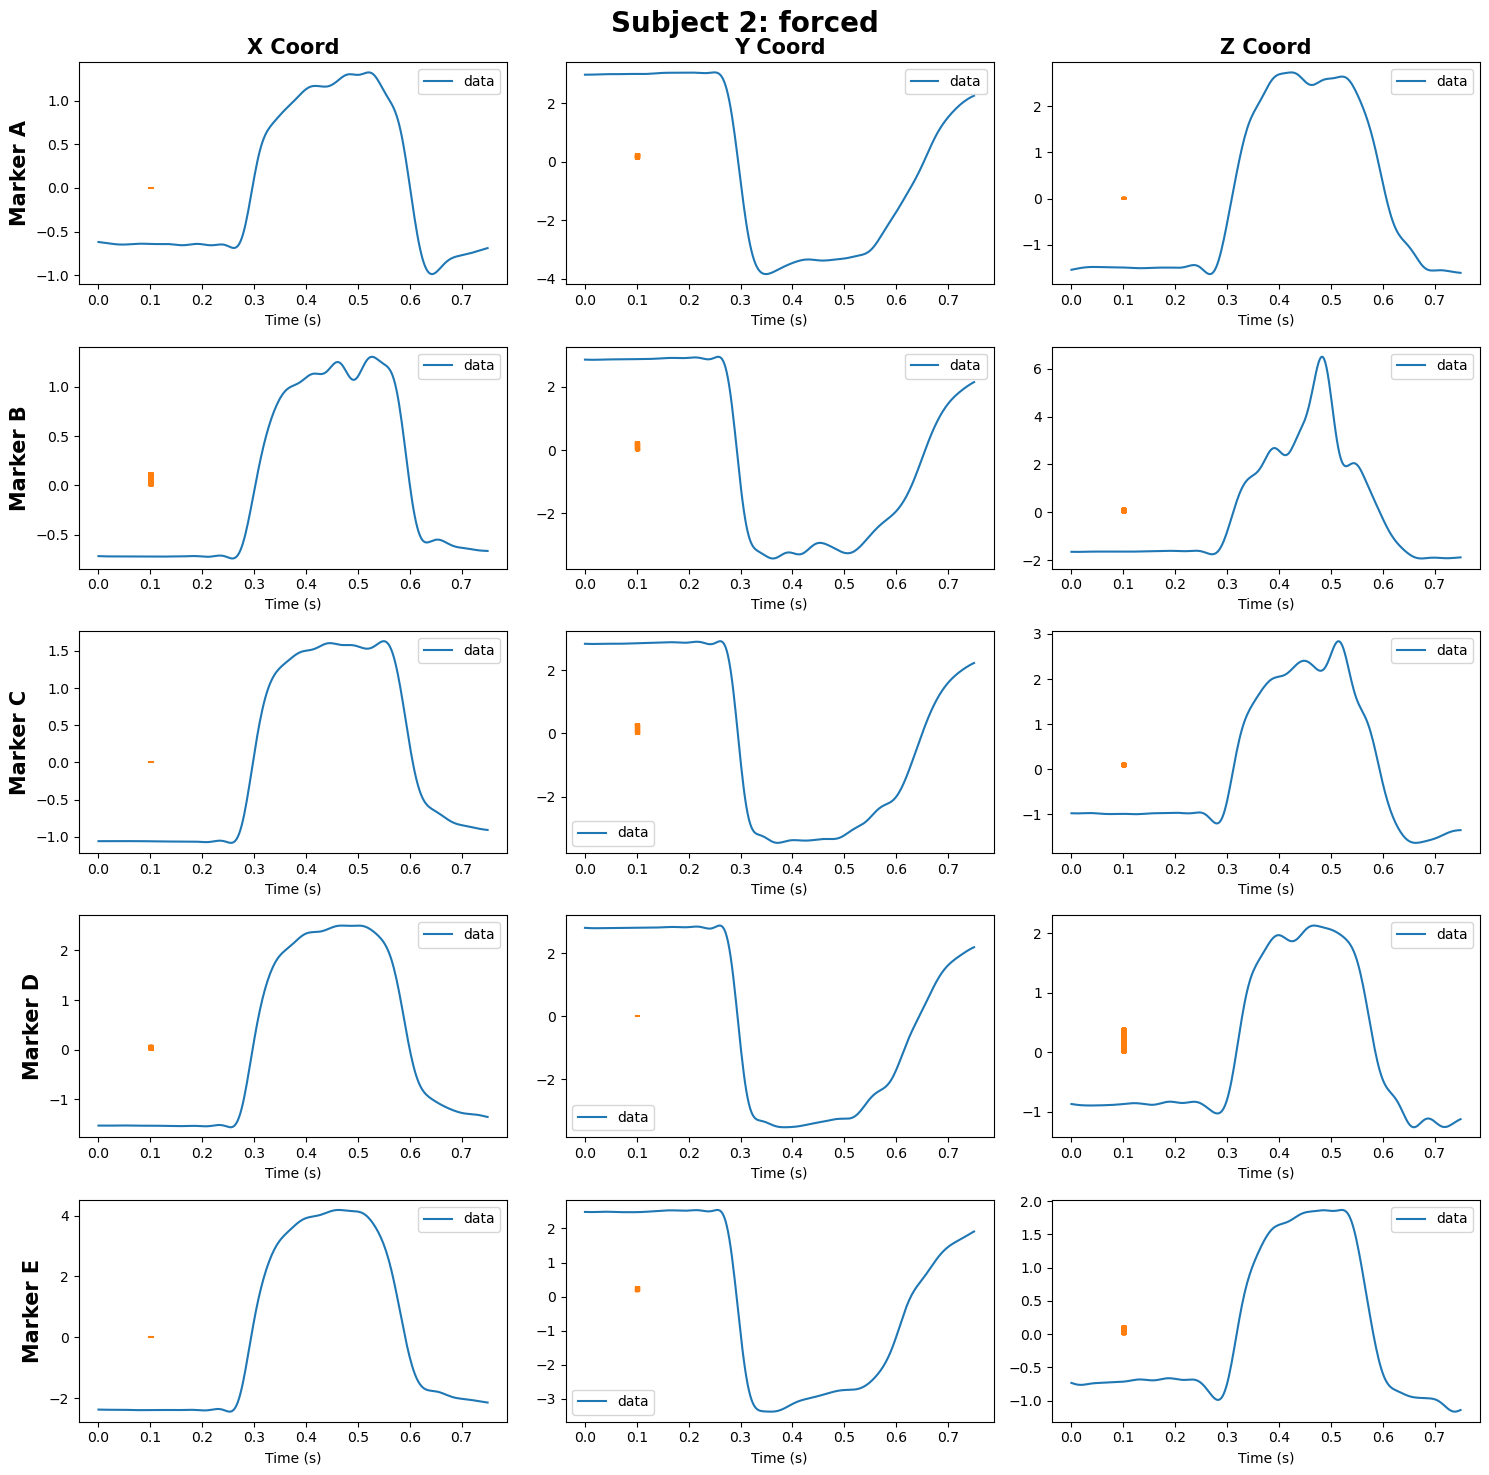

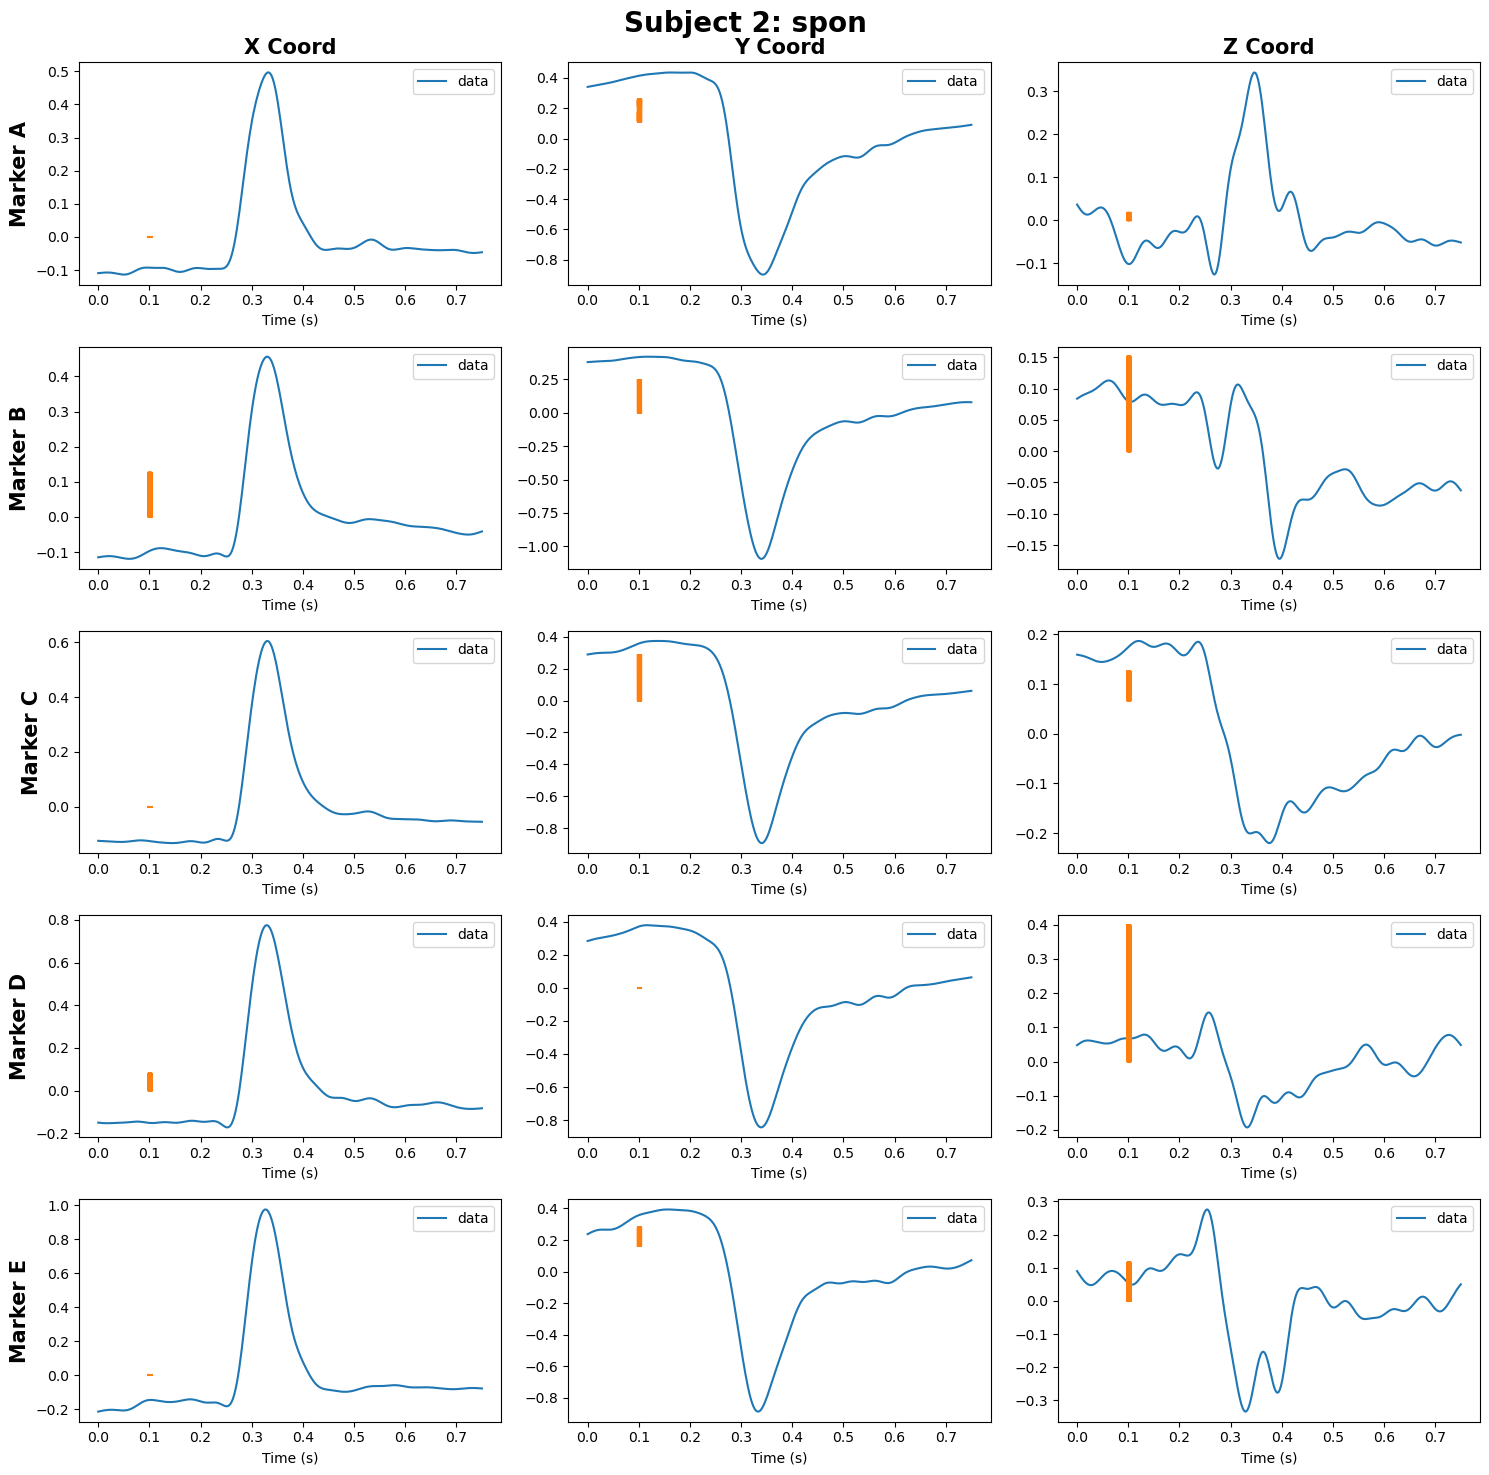

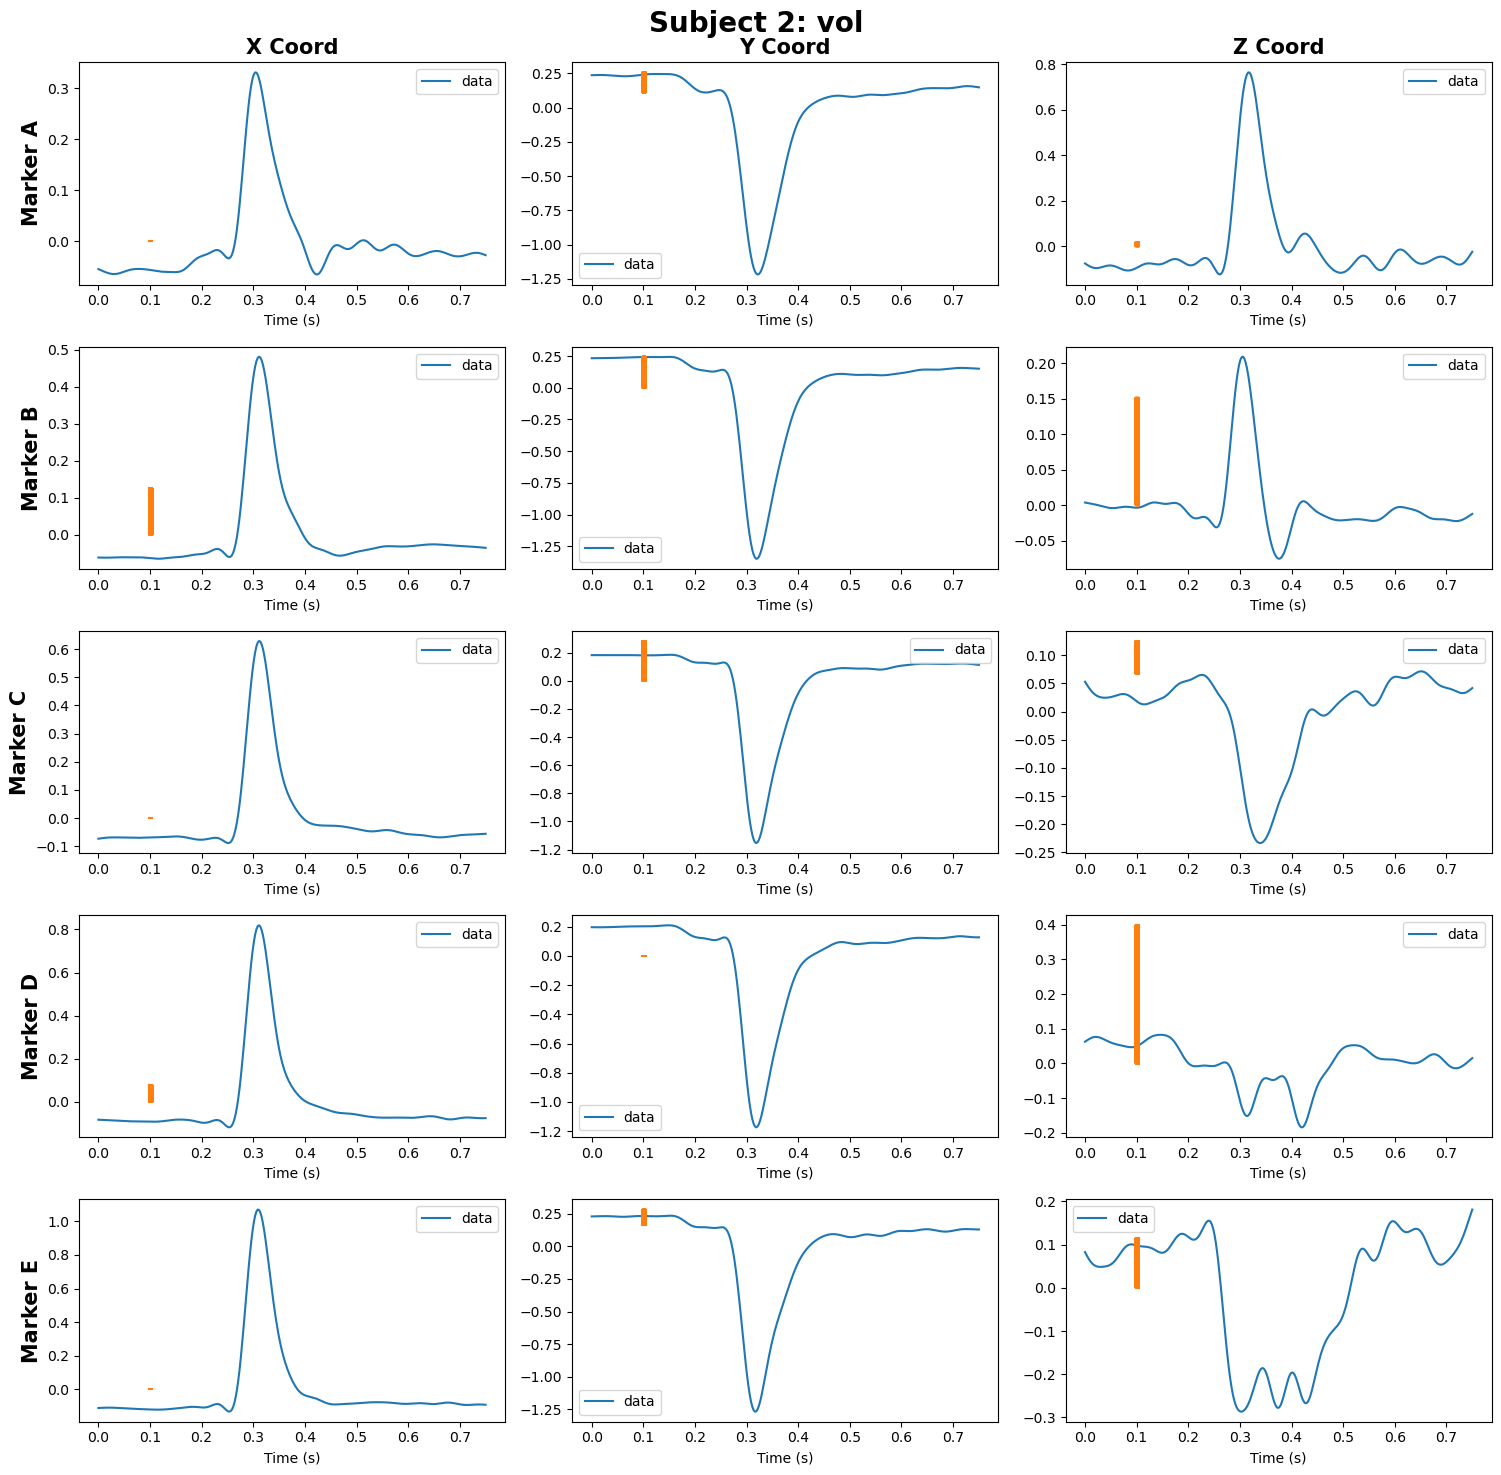

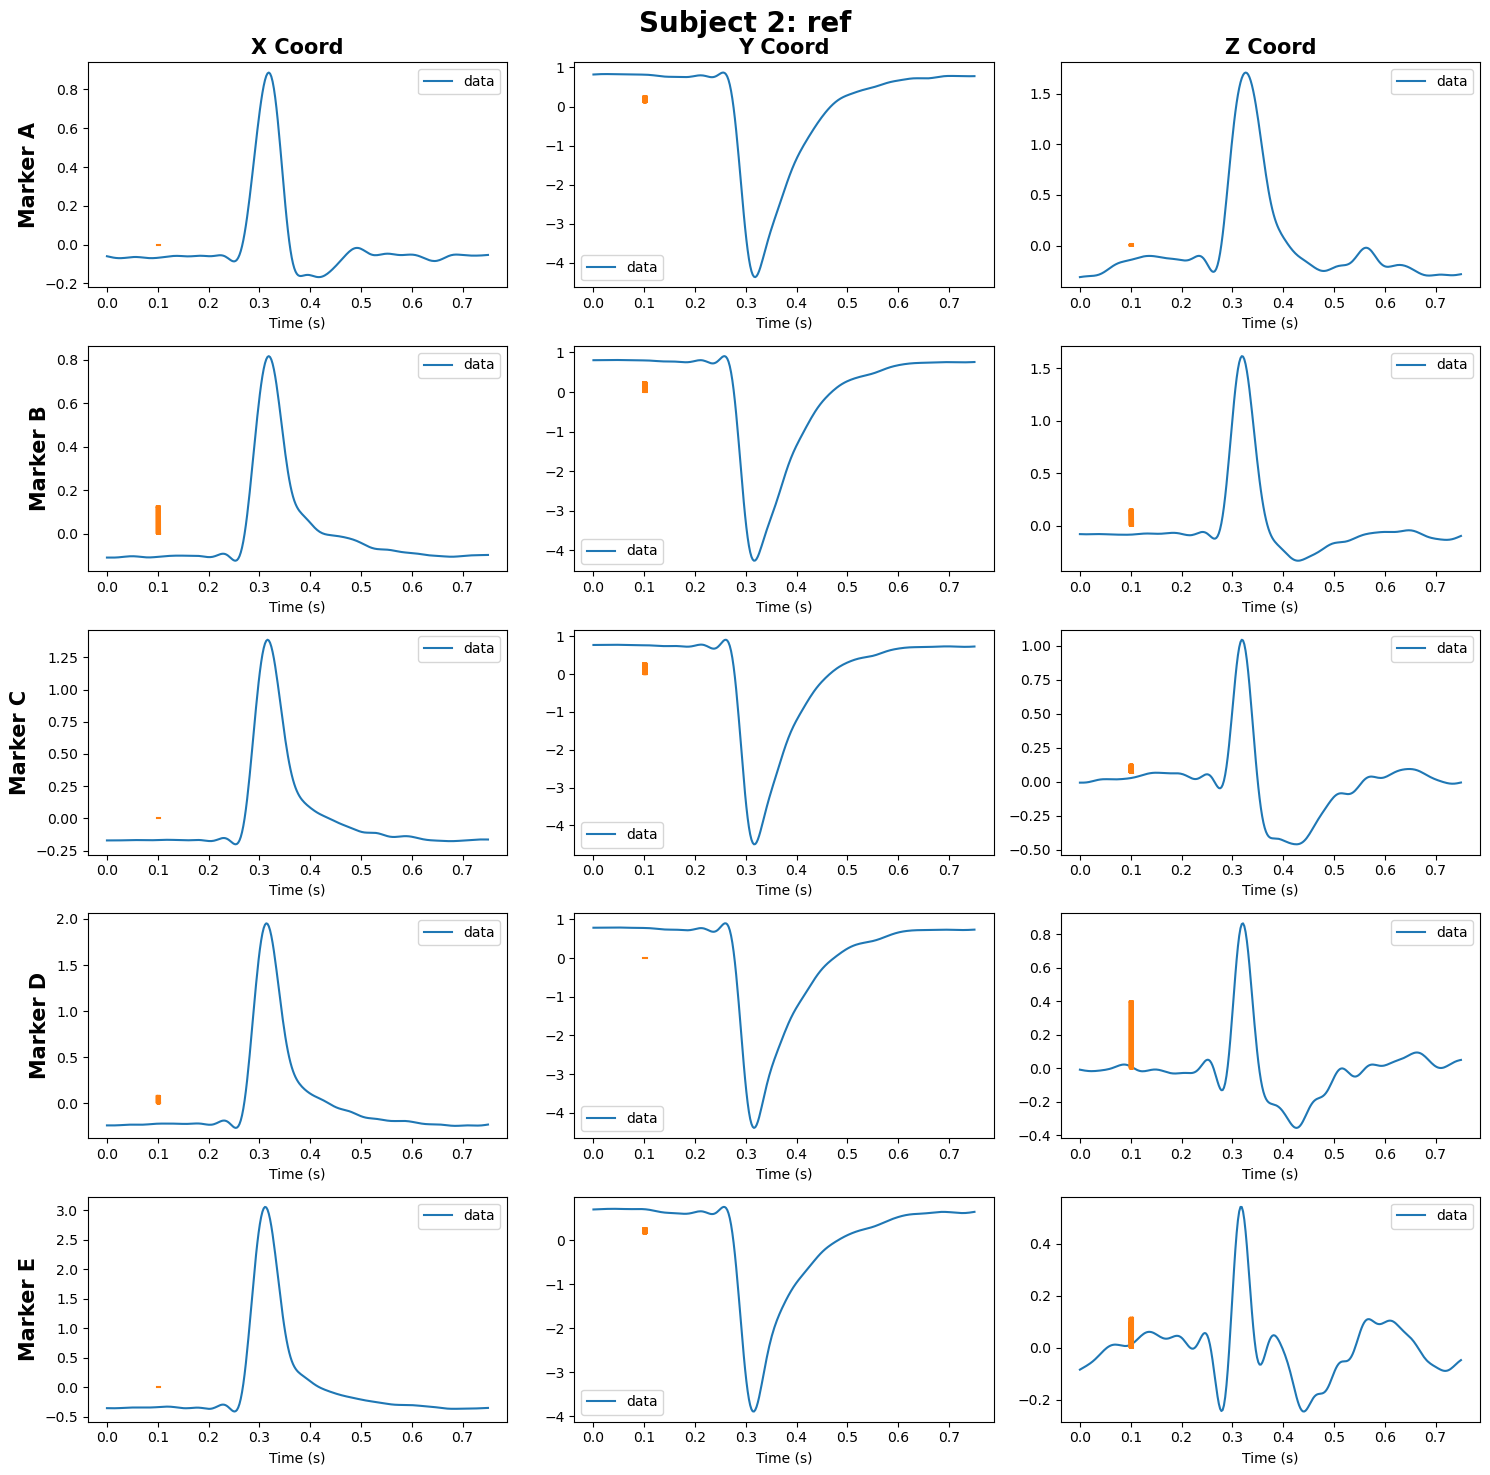

In [163]:
X, y = TVT_dict['X_val'], TVT_dict['y_val']
id = TVT_dict['id_val'] #CHANGE TO TEST ONCE YOU GET THERE
marker = ["A", "B", "C", "D", "E"]
coord = ["X", "Y", "Z"]

pred_ts, t = pred2ts(preds, best_params)

#obtain string of subjects/categories
sub = []
cat = []
for string in id:
    sub.append(string.split('_')[0])
    category = string.split('_')[1]
    cat.append(category.split('#')[0])
sub = np.asarray(sub)
cat = np.asarray(cat)

#obtain indices of each subject/category combo
idxs = {}
for s_num in set(sub):
    for cat_type in set(cat):
        cat_list = np.where(cat == str(cat_type))[0]
        sub_list = np.where(sub == str(s_num))[0]
        common = np.asarray(list(set(cat_list) & set(sub_list)))
        idxs[str(s_num) + '_' + str(cat_type)] = common

#Plot 
for cat_type in set(cat):
    fig, ax = plt.subplots(5, 3, figsize = (15, 15))
    for i in range(5):
        for j in range(3):
            idx = idxs['sub2_' + str(cat_type)][0]
            ax[i, j].plot(np.linspace(0, 0.75, 300), y[:, j, idx, i], label = 'data')
            ax[i, j].plot(t, pred_ts[idx, :, j, i])
            if j == 0:
                ax[i, j].set_ylabel("Marker " + str(marker[i]), weight = 'bold', fontsize = '15')
            if i == 0:
                ax[i, j].set_title(str(coord[j]) + " Coord", weight = 'bold', fontsize = '15')
            ax[i, j].set_xlabel("Time (s)")
            ax[i, j].legend()
    fig.suptitle('Subject 2: ' + str(cat_type), weight = 'bold', fontsize = '20')
    fig.tight_layout()

    
        